# Задача мэтчинга

**Цель** - выполнить задачу мэтчинга. Есть два множества объектов: A и B. Каждый объект множества описывается какими-то признаками.

**Задача** - для каждого объекта из множества A найти один или несколько объектов из B, которые близки к нему по некоторой заданной метрике.

**Согласно документации к данным**

- `base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный `id` (0-base, 1-base, 2-base) и вектор признаков размерностью 72.

- `train.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …) , вектор признаков и `id` товара из `base.csv`, который максимально похож на него (по мнению экспертов).

- `validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из `base.csv`

- `validation_answer.csv` - правильные ответы к предыдущему файлу.

Есть два датасета:
- Полная версия (данных более 2 Гб) хранится в файле - `data_full.zip`
- Уменьшенная версия (~10% от исходной) хранится в файле - `data.zip`

**План исследования**

1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционные анализ
5. Обучение моделей
6. Общий вывод

Для работы будем использовать FAISS. Целевая метрика - accuracy@n, где n = 5. Желательно достигнуть метрики больше 70%

# Изучение данных
## Импорт библиотек

In [2]:
!apt -q install libomp-dev
!pip -q install faiss-gpu
!pip -q install phik

Reading package lists...
Building dependency tree...
Reading state information...
libomp-dev is already the newest version (1:14.0-55~exp2).
0 upgraded, 0 newly installed, 0 to remove and 45 not upgraded.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 5.6 MB/s eta 0:00:00


In [3]:
import os
import warnings
import zipfile

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Импортируем сторонние библиотеки
import phik
from phik.report import plot_correlation_matrix

import faiss
from google.colab import drive

In [4]:
pd.set_option('display.max_columns', None)
warnings.simplefilter('ignore', UserWarning)

In [5]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Функции

In [6]:
def open_zip(size):
    '''
    Функция принимает размер датасета. Прочитывает
    zip файл и показывает, какие файлы в нем хранятся.
    Если же файлов нет или передан не верный аргумент
    функция выведет ошибку.

    '''

    zip_pth = "/content/drive/MyDrive/Colab Notebooks/data_full.zip"
    zip_pth1 = "/content/drive/MyDrive/Colab Notebooks/data.zip"

    if size not in ['small', 'full']:
        return 'Ошибка. Неизвестный аргумент'

    if size == 'small':
        if os.path.exists(zip_pth1):
            with zipfile.ZipFile(zip_pth1, "r") as zf:
                zf.extractall()

            with zipfile.ZipFile(zip_pth1, mode='a') as zf_name:
                for file in zf_name.namelist():
                    print(file)
        else:
            return 'Ошибка. Файл не найден'
    else:
        if os.path.exists(zip_pth):
            with zipfile.ZipFile(zip_pth, "r") as zf:
                zf.extractall()

            with zipfile.ZipFile(zip_pth, mode='a') as zf_name:
                for file in zf_name.namelist():
                    print(file)
        else:
            return 'Ошибка. Файл не найден'

In [7]:
def dupl(df):
    '''
    Функция принимает датафрейм и проверяет его
    на наличие дубликатов, если они есть то удаляет их

    '''

    dupl = df.duplicated().sum()  # Проверяем на наличие дубликатов

    if dupl != 0:
        print("\033[31m{}".format(
            f'Необходимо удалить дубликаты. Количество дубликатов: {dupl}'))

        df = df.drop_duplicates().reset_index(drop=True)  # Удаляем дубликаты
        dupl = df.duplicated().sum()  # Проверяем на наличие дубликатов

        print("\033[32m{}".format(
            f'Количество дубликатов после удаления: {dupl}'))

    else:
        print("\033[32m{}".format('Дубликатов нет'))

    return df

In [8]:
def test_shapiro(df, alpha):
    '''
    Функция принимает датафрейм, уровень значимости и проверяет
    распределение всех признаков при помощи теста Шапиро-Уилка.
    Считает количество распределений нормальных и ненормальных и
    выводит результат теста и списки признаков соотвествующих распределений.

    '''

    # Создаем счетчик распределений
    count_norm = 0
    count_abnorm = 0

    # Создаем списки столбцов распределений
    norm_column = []
    abnorm_column = []

    # Перебираем все столбцы датафрейма
    for column in range(len(df_base.columns)-1):

        # Проверяем гипотезу при помощи теста Шапиро-Уилка
        statistic, p = st.shapiro(df_base[str(column)])

        if p < alpha:
            count_abnorm += 1
            abnorm_column.append(str(column))
        else:
            count_norm += 1
            norm_column.append(str(column))

    print(
        f'Отвергаем H0 и принимаем H1 - {count_abnorm} раз. Данные не получены из нормального распределения.')
    print(
        f'Не отвергаем H0 - {count_norm} раз. Данные получены из нормального распредения.')
    return norm_column, abnorm_column

In [9]:
def test_grubbs(df, alpha, norm_column):
    '''
    Функция принимает датафрейм, уровень значимости и cписок
    столбцов нормально распределенных данных, выполняет тест Граббса
    для нахождения выбросов в данных. Выводит, количество признаков,
    в которых есть выбросы и возвращает списки со столбцами.

    '''

    # Создаем счетчик распределений
    count_outlier = 0
    count_not_outlier = 0

    # Создаем списки столбцов распределений
    outlier_column = []
    not_outlier_column = []

    # Перебираем все столбцы датафрейма
    for column in norm_column:

        n = len(df[column])
        mean_df = np.mean(df[column])
        sd_df = np.std(df[column])
        numerator = max(abs(df[column] - mean_df))

        # Находим значение Граббса
        g_calculated = numerator / sd_df

        # Используем двусторонний тест
        t_value = st.t.ppf(1 - alpha / (2 * n), n - 2)

        # Находим критическое значение Граббса
        g_critical = ((n - 1) * np.sqrt(np.square(t_value))) / \
            (np.sqrt(n) * np.sqrt(n - 2 + np.square(t_value)))

        # Сравниваем вычисленное значение с критическим значением
        if g_critical > g_calculated:
            count_not_outlier += 1
            not_outlier_column.append(column)
        else:
            count_outlier += 1
            outlier_column.append(column)

    print(
        f"Принимаем H0 - {count_not_outlier} раз и делаем вывод об отсутствии выбросов")
    print(
        f"Отклоняем H0 и принимаем H1 - {count_outlier} раз и делаем вывод, что есть выбросы")

    return outlier_column, not_outlier_column

In [10]:
def outliers_iqr(df, abnorm_column):
    '''
    Функция принимает на вход датафрейм и список столбцов
    с ненормально распределенными данными. Она считает
    1 и 3 квантиль и межквантильный размах. После этого
    значения, которые находятся ниже или выше iqr * 1.5
    и заменяет их либо на верхнее, либо на нижнее значение границы.

    '''

    for column in abnorm_column:

        q1 = df[column].quantile(0.25)
        q3 = df[column].quantile(0.75)

        iqr = q3-q1

        upper = df[column][~(df[column] > (q3+1.5*iqr))].max()
        lower = df[column][~(df[column] < (q1-1.5*iqr))].min()

        df[column] = np.where(df[column] > upper,
                              upper, np.where(df[column] < lower,
                                              df[column].mean(),
                                              lower))

    return df

## Константы

In [11]:
# Задаем уровень значимости
ALPHA = 0.05

## Загрузка данных

Для чтения zip-файлов была написана функция `open_zip`, которая принимает на вход аргумент о размере датасета (`small` или `full`). В результате функция читает нужный архив и выводит названия файлов, которые в нем находятся.

In [47]:
open_zip('full')  # Вызваем функцию

base.csv
train.csv
validation.csv
validation_answer.csv


Прочитаем файлы `base.csv`, `train.csv`, `validation.csv` и `validation_answer.csv` и сохраним их в переменных `df_base`, `df_train`, `df_validation` и `df_answer`.

In [48]:
df_base = pd.read_csv('base.csv', index_col=0)  # Читаем файл из архива

In [49]:
df_train = pd.read_csv('train.csv', index_col=0)  # Читаем файл из архива

In [50]:
df_validation = pd.read_csv(
    'validation.csv', index_col=0)  # Читаем файл из архива

In [51]:
df_answer = pd.read_csv('validation_answer.csv',
                        index_col=0)  # Читаем файл из архива

Выведем первые 2 строчки всех таблиц, чтобы убедиться, что данные анонимизированны.

In [17]:
df_base.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.42676,-118.88089,216.482440,-104.69806,-469.070588,44.348083,120.915344,181.44970,-124.06151,-32.458237,-57.42056,36.207405,182.71677,-28.071688,-5.209374,-1.732182,-91.09186,-79.46667,-103.93909,1507.231274,-32.591667,51.414360,-51.90536,813.770071,-41.556538,8.419807,-129.976640,148.76503,-10.069234,-143.00504,79.848694,-537.183707,2.77318,111.518680,4.257666,-153.34058,-123.62608,-39.707664,-12.768708,-4.170106,-152.967130,75.911520,-57.470088,17.266476,-98.871155,-138.06754,91.000380,-170.702000,-50.02039,59.794296,78.106380,-89.375725,89.412100,79.81218,-129.51361,-44.659496,-80.44221,5.149714,-64.518950,-138.77763,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.93361,115.26919,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.78761,-166.53348,57.680607,-86.09837,-85.076666,-35.637436,119.718636,195.23419,-141.30435,-126.768900,-68.85353,8.314717,143.08174,8.778257,15.157185,48.246360,-244.95486,-80.27942,-81.78804,429.880035,-5.937690,70.142654,66.57684,813.770071,3.214371,17.164303,-39.418385,148.15588,-7.579590,-174.36995,101.224630,-303.939233,16.91463,53.394676,33.451824,-148.55263,-110.34017,-33.277206,-8.688703,13.650302,-91.228745,38.445015,-31.948470,62.484820,-166.473360,-189.01042,-56.731556,-30.027319,59.17106,-56.711540,63.542606,-121.319170,97.426056,74.83284,-138.77705,58.887608,-71.59534,-251.952358,11.392853,-148.57166,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.93793,116.83400,-84.888941,-59.524610


In [18]:
df_train.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.51749,-87.14493,-347.360606,38.307602,109.08556,30.413513,-88.08269,-52.695540,-27.692442,4.872923,198.348000,-30.075249,-3.803569,-135.810610,-161.84137,-78.51218,-94.42894,898.436927,-70.140520,78.42036,108.032776,813.770071,-74.79088,12.610422,-183.82184,149.71584,-27.042316,-133.21217,106.420746,-303.939233,48.73079,58.185707,24.25095,-151.22410,-104.282265,-34.492810,-12.587054,2.622891,-120.96992,149.99164,-31.948470,82.314430,-115.830470,-243.30939,6.622036,-132.197660,68.71256,-38.806824,62.937435,-132.65445,89.189026,87.039780,-121.27988,-6.986934,-206.51382,29.485587,-77.029590,-132.38617,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.76360,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.80333,-83.81059,-94.572749,-78.433090,124.91590,140.331070,-177.60580,-84.995514,42.810810,-57.256332,96.792534,-19.261467,0.739535,50.619213,-155.26703,-78.65943,-92.76149,353.157741,-34.744545,82.48711,-28.450592,813.770071,-137.52963,26.595627,-136.78345,153.35791,48.810093,-115.92215,87.464220,-222.286354,25.12415,91.887140,-30.63687,-136.59314,-140.500120,-43.449757,-7.226884,8.265747,-117.91547,149.15090,-18.751057,95.315384,-60.093273,-83.82058,37.449867,-23.298859,74.06108,-7.139753,75.862400,-112.04511,82.857730,54.067215,-134.00539,-26.142574,-214.63211,-457.848461,21.459618,-137.41136,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.58963,-1035.092211,-51.276833,366656-base


In [19]:
df_validation.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,-131.89280,-140.96857,-57.987164,-22.868887,150.89552,7.965574,17.622066,-34.868217,-216.13855,-80.908730,-52.57952,263.363136,56.266876,66.924710,21.609911,813.770071,-32.78294,20.794031,-79.779076,156.30708,-42.831330,-71.723335,83.28366,-304.174382,1.609402,55.834587,-29.474255,-139.16277,-126.03835,-62.643830,-5.012346,11.984920,-43.084946,190.12400,-24.996636,76.15390,-245.26157,-143.65648,-4.259628,-46.664196,-27.085403,-34.346962,75.530106,-47.171707,92.697320,60.475630,-127.48687,-39.484753,-124.384575,-307.949760,45.506813,-144.19095,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.07936
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,-153.71725,-63.95133,-52.369495,-33.390945,148.61950,-22.483830,15.164185,-56.202000,-153.61438,-79.831825,-101.05548,1203.537156,81.597130,101.018654,56.783424,92.209628,-126.86034,10.382887,-38.523360,165.38391,-77.840485,-169.538680,103.48324,-915.735701,16.109938,14.669937,-38.707085,-149.53838,-138.79292,-36.076176,-2.781422,2.283144,-142.477890,189.95395,-18.408230,90.51705,-95.53100,-259.63605,52.437836,-30.004599,14.502060,-1.071201,66.842670,-161.279890,94.794174,50.419983,-125.07526,-25.169033,-176.176880,-655.836897,-99.238370,-141.53522,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.00932


In [20]:
df_answer.head(2)

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base


Как и было сказано в документации к данным, все данные анонимизированны, что мы и наблюдаем.

Посмотрим на общую информацию о данных в таблицах.

In [21]:
df_base.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 72 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float64
 1   1       float64
 2   2       float64
 3   3       float64
 4   4       float64
 5   5       float64
 6   6       float64
 7   7       float64
 8   8       float64
 9   9       float64
 10  10      float64
 11  11      float64
 12  12      float64
 13  13      float64
 14  14      float64
 15  15      float64
 16  16      float64
 17  17      float64
 18  18      float64
 19  19      float64
 20  20      float64
 21  21      float64
 22  22      float64
 23  23      float64
 24  24      float64
 25  25      float64
 26  26      float64
 27  27      float64
 28  28      float64
 29  29      float64
 30  30      float64
 31  31      float64
 32  32      float64
 33  33      float64
 34  34      float64
 35  35      float64
 36  36      float64
 37  37      float64
 38  38      float64
 39  39      float64


In [22]:
df_base.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06,2.918139e+06
mean,-8.622947e+01,8.080077e+00,-4.458080e+01,-1.466350e+02,1.113166e+02,-7.199138e+01,-3.922239e+02,2.035283e+01,1.236842e+02,1.244581e+02,-1.431396e+02,-6.988662e+01,-4.126493e+01,7.587780e+00,1.489852e+02,-2.316701e+01,-9.366916e-01,-1.931312e+01,-1.372712e+02,-7.918932e+01,-9.825383e+01,1.257528e+03,-6.824936e+00,5.667382e+01,2.669563e+01,7.271026e+02,-6.625340e+01,1.631537e+01,-8.637482e+01,1.517346e+02,-1.160764e+01,-1.442328e+02,8.721997e+01,-5.541608e+02,3.623933e+01,7.519918e+01,-1.648670e+01,-1.466421e+02,-1.185122e+02,-4.187896e+01,-9.482269e+00,4.050654e+00,-1.127440e+02,1.208653e+02,-3.980939e+01,5.893878e+01,-8.488885e+01,-1.384695e+02,4.792759e+01,-3.238229e+01,2.658408e+01,-2.171709e+01,6.699684e+01,-1.178976e+02,8.802818e+01,6.920454e+01,-1.329056e+02,1.322645e+01,-1.195996e+02,-3.160935e+02,-6.494332e+01,-1.306677e+02,-7.902286e+01,3.329735e+01,-1.547962e+02,1.415132e+01,6.779167e+01,2.354490e+01,7.495930e+01,1.155667e+02,-7.993390e+02,-4.779125e+01
std,2.489132e+01,4.953387e+00,3.863166e+01,1.984480e+01,4.634809e+01,2.818607e+01,2.716550e+02,6.421638e+01,6.356109e+00,6.443058e+01,4.168737e+01,5.121991e+01,3.896358e+01,3.659725e+01,3.363559e+01,1.307563e+01,2.083201e+01,5.297210e+01,4.662566e+01,7.574403e-01,2.815861e+01,3.999612e+02,5.197251e+01,3.436061e+01,3.894157e+01,2.055724e+02,6.153334e+01,4.656628e+00,4.851313e+01,1.009000e+01,2.895059e+01,3.475739e+01,2.785556e+01,2.606486e+02,3.989506e+01,2.144713e+01,2.585462e+01,9.953913e+00,1.314411e+01,1.919689e+01,8.190720e+00,5.835750e+00,5.694050e+01,4.671995e+01,1.474482e+01,3.211030e+01,6.319335e+01,5.773822e+01,4.520157e+01,5.828693e+01,5.895291e+01,5.173898e+01,1.307173e+01,5.470584e+01,4.774309e+00,1.194907e+01,7.815245e+00,5.107988e+01,5.524317e+01,2.106644e+02,6.248236e+01,9.569063e+00,3.045642e+01,2.888603e+01,4.122929e+01,9.895115e+01,1.823356e+00,5.534224e+01,6.134500e+01,2.117518e+01,3.854131e+02,4.174802e+01
min,-1.994687e+02,-1.391461e+01,-2.400734e+02,-2.326671e+02,-1.055830e+02,-2.110086e+02,-7.914699e+02,-3.018597e+02,9.315305e+01,-1.738719e+02,-3.438436e+02,-3.684526e+02,-2.260906e+02,-1.756239e+02,-1.526698e+01,-8.591711e+01,-9.636816e+01,-2.725656e+02,-3.517478e+02,-8.315235e+01,-2.437279e+02,1.368182e+02,-2.382874e+02,-8.818329e+01,-1.431833e+02,-6.198046e+01,-3.585515e+02,-8.364693e+00,-3.140082e+02,1.074433e+02,-1.567305e+02,-2.986792e+02,-3.465488e+01,-1.045312e+03,-1.378509e+02,-2.151936e+01,-1.379866e+02,-1.954172e+02,-1.769110e+02,-1.327073e+02,-4.757769e+01,-2.158085e+01,-3.381192e+02,-8.770834e+01,-6.310310e+01,-7.724959e+01,-3.629306e+02,-4.186953e+02,-1.453876e+02,-3.228121e+02,-2.802731e+02,-2.646334e+02,6.196133e+00,-3.812643e+02,6.558115e+01,1.408166e+01,-1.670627e+02,-1.961836e+02,-3.597054e+02,-6.810424e+02,-4.007911e+02,-1.713491e+02,-2.205662e+02,-8.850774e+01,-3.539028e+02,-1.575944e+02,5.95094

Рассмотрим полученную информацию подробнее.

Всего в таблице 72 столбца, тип данных - `float`(72). Хоть данные у нас и анонимизированны, но исходя из описательной статистики можно заметить, что у многих признаков сильно отличается значение медианы и среднего, что может говорить о наличии выбросов. Необходимо более детально изучить столбцы.

In [23]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 0-query to 99999-query
Data columns (total 73 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21  21  

In [24]:
df_train.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.328679,7.664345,-43.667046,-146.118630,111.770592,-73.178792,-440.615118,21.231588,123.067891,126.120201,-141.168584,-69.228444,-42.559541,6.506719,149.077582,-23.942253,-2.219093,-12.964439,-138.714610,-79.159795,-97.474574,1297.269578,-3.600685,55.908014,23.470181,742.788817,-64.970553,16.368072,-86.201170,152.098083,-13.659323,-144.506022,89.747894,-587.551768,36.468210,73.109595,-13.866967,-146.487267,-118.336458,-41.131969,-9.261504,4.139978,-104.928806,122.240784,-40.320211,59.051981,-84.054387,-140.787854,46.137851,-34.136875,29.462927,-22.343451,67.581086,-120.052756,88.193676,69.538752,-132.336967,14.452681,-120.301843,-315.282239,-66.378660,-130.672183,-81.145553,36.898233,-152.223082,14.001695,67.799560,23.029277,73.412076,115.189717,-709.761548,-48.505704
std,25.803845,4.955651,39.111064,20.434841,47.700958,28.718853,279.017550,65.985214,6.492081,64.912752,41.607785,51.258647,40.819544,37.593800,34.167843,13.024184,20.978943,55.210920,48.737245,0.775560,28.382144,375.123794,50.063680,35.617513,40.802653,191.052074,63.160650,4.828575,49.511818,10.392531,29.191689,35.816357,28.312124,273.294442,39.756311,20.008170,25.824911,10.383975,13.578397,19.868303,8.295381,5.922103,56.519443,48.109909,14.739497,31.088173,66.055063,59.851232,46.328286,59.325454,60.934591,54.991787,12.988132,55.920785,4.824051,12.339684,7.952113,49.234745,55.730177,210.657513,64.913422,9.408099,30.675871,25.357686,41.020285,99.079597,1.838012,55.470761,62.203132,21.582238,405.961084,41.215124
min,-186.280270,-11.560507,-224.896060,-223.307220,-93.272020,-184.962450,-791.469482,-278.582820,94.831150,-142.156950,-330.570600,-352.405200,-214.742460,-145.860280,8.818390,-82.645004,-91.657020,-247.589280,-326.648740,-82.637184,-228.808260,136.873137,-211.971800,-87.323780,-122.584274,-61.803358,-338.562500,-6.629074,-285.668700,111.387250,-130.444920,-290.124000,-25.550720,-1044.135662,-119.903810,-11.926712,-124.560380,-193.918150,-166.078460,-123.062420,-43.063824,-18.980648,-324.943570,-67.540375,-63.102401,-64.789690,-327.322720,-365.060880,-129.879180,-280.371830,-250.337570,-236.148470,18.477040,-354.915700,66.068665,18.104557,-161.189320,-183.849880,-330.638180,-681.029305,-358.460450,-169.566400,-210.059310,-60.779335,-317.831670,-157.590189,60.668890,-203.746380,-181.973820,22.598862,-1297.871984,-209.935760
25%,-103.309147,4.313784,-69.494487,-160.028520,79.474322,-92.834080,-738.536868,-22.131764,118.674642,82.545028,-168.599020,-103.048815,-69.801705,-18.815189,126.369124,-32.379752,-16.455603,-49.612492,-171.661355,-79.656816,-115.407545,1248.126198,-37.047511,31.436791,-5.051067,813.770071,-106.860569,13.187895,-119.613590,145.143008,-32.812503,-168.535163,70.432237,-803.390708,9.505674,59.978086,-30.926924,-153.339210,-127.603408,

Рассмотрим полученную информацию подробнее.

Всего в таблице 73 столбца, тип данных - `float`(72) и `object`(1). Количестов значений в столбцах одинаковое, а значит пропусков нет. Аналогичная ситуация по описательной статистики. Можно заметить, что у многих признаков сильно отличается значение медианы и среднего, что может говорить о наличии выбросов.

In [25]:
df_validation.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 72 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   0       100000 non-null  float64
 1   1       100000 non-null  float64
 2   2       100000 non-null  float64
 3   3       100000 non-null  float64
 4   4       100000 non-null  float64
 5   5       100000 non-null  float64
 6   6       100000 non-null  float64
 7   7       100000 non-null  float64
 8   8       100000 non-null  float64
 9   9       100000 non-null  float64
 10  10      100000 non-null  float64
 11  11      100000 non-null  float64
 12  12      100000 non-null  float64
 13  13      100000 non-null  float64
 14  14      100000 non-null  float64
 15  15      100000 non-null  float64
 16  16      100000 non-null  float64
 17  17      100000 non-null  float64
 18  18      100000 non-null  float64
 19  19      100000 non-null  float64
 20  20      100000 non-null  float64
 21

In [26]:
df_validation.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,-85.302233,7.669724,-43.842474,-146.119797,111.635071,-73.273042,-441.396759,21.594242,123.077725,126.001062,-141.215384,-69.340237,-42.626768,6.272022,149.006081,-23.961728,-2.009594,-13.151269,-138.540600,-79.162680,-97.356361,1301.395163,-3.439855,56.097825,23.357262,741.156981,-64.986388,16.367853,-86.139332,152.078754,-13.476064,-144.568331,89.709031,-588.597042,36.554961,73.085400,-13.889099,-146.461500,-118.391474,-40.992214,-9.193917,4.157828,-104.775965,122.095524,-40.311826,59.123753,-83.620997,-141.003063,46.187760,-34.154328,29.404870,-22.542637,67.486142,-120.307717,88.174847,69.495540,-132.377437,14.411927,-120.381837,-316.401557,-66.614887,-130.653256,-81.129311,36.778882,-152.341249,14.397762,67.788892,23.250779,73.114446,115.196935,-709.457021,-48.416276
std,25.777321,4.956990,39.138775,20.495541,47.751576,28.515740,279.242585,66.478048,6.504931,64.981697,41.568432,51.483403,40.858017,37.845939,34.031665,13.014670,20.993654,55.340411,48.790143,0.777431,28.503558,371.543911,50.291410,35.599512,40.849607,193.199671,63.274623,4.845841,49.511970,10.406558,29.275776,35.911251,28.430405,273.788805,39.610961,20.044353,25.802824,10.389778,13.602543,19.845968,8.364438,5.910225,56.986969,48.130993,14.753263,31.126990,65.925312,59.595488,45.996789,59.611850,60.943297,55.140398,13.036243,56.107653,4.809309,12.324416,7.894675,49.387024,55.818220,211.131373,65.195278,9.426921,30.691590,25.427103,41.246347,98.695231,1.844522,55.403862,62.056224,21.493081,405.665764,41.292843
min,-190.353330,-11.109877,-217.538420,-220.050890,-81.198990,-176.705030,-791.460243,-265.608430,96.218350,-135.667300,-321.544250,-363.493320,-204.299130,-144.100740,-14.816055,-78.597450,-86.843280,-272.565600,-329.860170,-82.665300,-231.376650,136.846377,-208.900850,-84.224530,-138.217000,-61.879841,-341.962220,-6.662937,-282.249330,110.357254,-150.154720,-281.123540,-24.076744,-1044.135662,-117.473145,-17.641396,-124.311615,-194.132930,-166.124450,-126.336075,-43.321170,-19.319794,-326.301300,-79.304720,-63.102401,-76.792040,-365.282530,-375.452200,-121.267914,-277.375920,-279.886380,-234.521500,12.404751,-381.609380,65.986030,17.301888,-162.872990,-156.581590,-329.700800,-681.038139,-339.966340,-168.735570,-215.152280,-66.265970,-337.632870,-157.593541,60.377728,-210.672800,-175.921780,25.271042,-1297.923999,-209.935760
25%,-103.231790,4.292425,-69.680916,-160.210287,79.101920,-92.789803,-740.620025,-21.804730,118.657689,82.311205,-168.562772,-103.338022,-70.147153,-19.089412,126.442184,-32.356516,-16.392179,-49.942476,-171.695623,-79.665475,-115.390365,1248.126198,-36.891637,31.741733,-5.265194,813.770071,-107.339855,13.182383,-119.527813,145.126130,-32.815898,-168.729353,70.166879,-803.390708,9.700724,59.971492,-30.786210,-153.332742,-127.66153

Рассмотрим полученную информацию подробнее.

Всего в таблице 72 столбца, тип данных - `float`(72). Количестов значений в столбцах одинаковое, а значит пропусков нет. Аналогичная ситуация по описательной статистики. У многих признаков сильно отличается значение медианы и среднего, что может говорить о наличии выбросов.

In [27]:
df_answer.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100000 entries, 100000-query to 199999-query
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   Expected  100000 non-null  object
dtypes: object(1)
memory usage: 1.5+ MB


Рассмотрим полученную информацию подробнее.

Всего в таблице 1 столбец, тип данных - `object`(1). Количестов значений в столбцах одинаковое, а значит пропусков нет. Описательная статистику к этому датафрейму не применить, так как содержит только не числовые признаки.

## Вывод

Каждая сторка таблицы содержит информацию о товаре. Что необходимо будет сделать:

- Хоть первичный просмотр данных и не показал наличие пропусков. Лучше еще раз проверить их.
- Сделать проверку на явные и неявные дубликаты.

# Предобработка данных
## Работа с пропусками

Проверим наличие пропусков в датафреймах и их долю от общего числа

In [28]:
count_na = pd.Series(df_base.isna().sum(), name='Пропуски')

In [29]:
proportion = pd.Series(
    (df_base.isna().sum() / len(df_base)).round(4) * 100, name='Доля')

In [30]:
pd.concat([count_na, proportion], axis=1).sort_values(
    by='Пропуски', ascending=False)

,Пропуски,Доля
0,0,0.0
1,0,0.0
52,0,0.0
51,0,0.0
50,0,0.0
...,...,...
23,0,0.0
22,0,0.0
21,0,0.0
20,0,0.0


In [31]:
count_na_train = pd.Series(df_train.isna().sum(), name='Пропуски')

In [32]:
proportion_train = pd.Series(
    (df_train.isna().sum() / len(df_train)).round(4) * 100, name='Доля')

In [33]:
pd.concat([count_na_train, proportion_train], axis=1).sort_values(
    by='Пропуски', ascending=False)

,Пропуски,Доля
0,0,0.0
37,0,0.0
53,0,0.0
52,0,0.0
51,0,0.0
...,...,...
24,0,0.0
23,0,0.0
22,0,0.0
21,0,0.0


In [34]:
count_na_val = pd.Series(df_validation.isna().sum(), name='Пропуски')

In [35]:
proportion_val = pd.Series(
    (df_validation.isna().sum() / len(df_validation)).round(4) * 100, name='Доля')

In [36]:
pd.concat([count_na_val, proportion_val], axis=1).sort_values(
    by='Пропуски', ascending=False)

,Пропуски,Доля
0,0,0.0
1,0,0.0
52,0,0.0
51,0,0.0
50,0,0.0
...,...,...
23,0,0.0
22,0,0.0
21,0,0.0
20,0,0.0


In [37]:
count_na_asw = pd.Series(df_answer.isna().sum(), name='Пропуски')

In [38]:
proportion_asw = pd.Series(
    (df_answer.isna().sum() / len(df_answer)).round(4) * 100, name='Доля')

In [39]:
pd.concat([count_na_asw, proportion_asw], axis=1)

,Пропуски,Доля
Expected,0,0.0


Еще раз убедились, что пропусков в датафреймах нет.

## Работа с явными дубликатами

Проверим данные на явные дубликаты, если они есть то удалим их. Для этого напишем функцию `dupl`, которая принимает датафрейм и проверяет на наличие дубликатов, если они есть то функция удаляет их и выводит сколько было дубликатов. В противном случае функция выдаст, что дубликатов нет.

In [40]:
df_base = dupl(df_base)

Дубликатов нет


In [41]:
df_train = dupl(df_train)

Дубликатов нет


In [42]:
df_validation = dupl(df_validation)

Дубликатов нет


## Работа с неявными дубликатами

Проверим столбец `Target` и `Expected` на неявные дубликаты. Возомжно, в каких-то местах отличается регистр или же есть пробелы в конце или в начале строки.

In [43]:
df_train['Target'] = df_train['Target'].str.strip().str.lower()

In [44]:
df_answer['Expected'] = df_answer['Expected'].str.strip().str.lower()

## Вывод

На данном этапе были сделаны следующие действия:

- Сделали проверку на пропуски в данных. В результате пропуски не были найдены.
- Сделали проверку на явные дубликаты  и удалили их.
- Для устранения не явных дубликатов, если они были. В столбцах `Target` и `Expected` привели все значения к нижнему регистру, а также удалили пробелы в начале и в конце.

# Исследовательский анализ данных

Анализ будем проводить только для `df_base`, так как тренировочный и валидационый датафреймы были получены из него, а следовательно к ним применимы теже выводы, что и к основному, так как данные выборки репрезентативны.

Визуализируем два любых столбца и построим боксплот и гистограмму распределения.

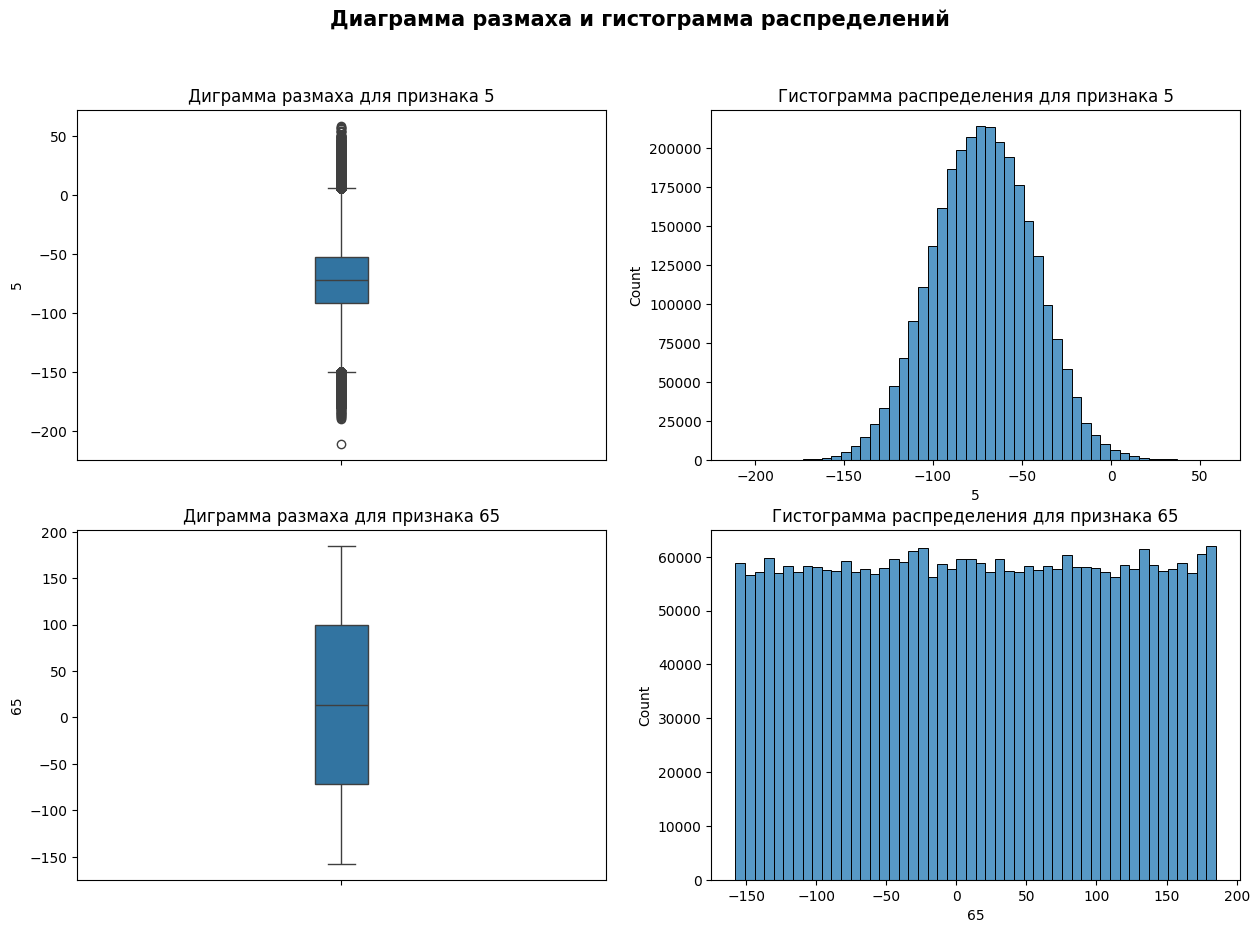

In [44]:
plt.figure(figsize=(15, 10))

plt.suptitle('Диаграмма размаха и гистограмма распределений',
             fontsize=15, fontweight='bold')

plt.subplot(2, 2, 1)
sns.boxplot(y=df_base['5'], width=.1)
plt.title('Диграмма размаха для признака 5')

plt.subplot(2, 2, 2)
sns.histplot(data=df_base, x='5', bins=50)
plt.title('Гистограмма распределения для признака 5')

plt.subplot(2, 2, 3)
sns.boxplot(y=df_base['65'], width=.1)
plt.title('Диграмма размаха для признака 65')

plt.subplot(2, 2, 4)
sns.histplot(data=df_base, x='65', bins=50)
plt.title('Гистограмма распределения для признака 65');

Можно предположить, что у нас некоторые данные распределены нормально,а некоторые ненормально. Также как видно из boxplot есть выбросы у признака 5, так как все признаки рассмотреть визуально довльно сложно. Воспользуемся статистическими тестами для определния выбросов и нормальности распределения.

Чтобы проверить все 72 столбца и узнать как распределенны данные. Выдвеним гипотезы и проверим их при помощи статистического теста Шапиро-Уилка.

- **H0** - Данные получены из нормального распределения
- **H1** - Данные не получены из нормального распределения

Для этого была написана функция `test_shapiro`.

In [45]:
norm_column, abnorm_column = test_shapiro(df_base, ALPHA)

Отвергаем H0 и принимаем H1 - 32 раз. Данные не получены из нормального распределения.
Не отвергаем H0 - 39 раз. Данные получены из нормального распредения.


Визуализируем по отдельности нормально и ненормально распределенные данные, чтобы проверить нетолько статистически распределения. Для этого применим к датафрейму `df_base` метод `hist`.

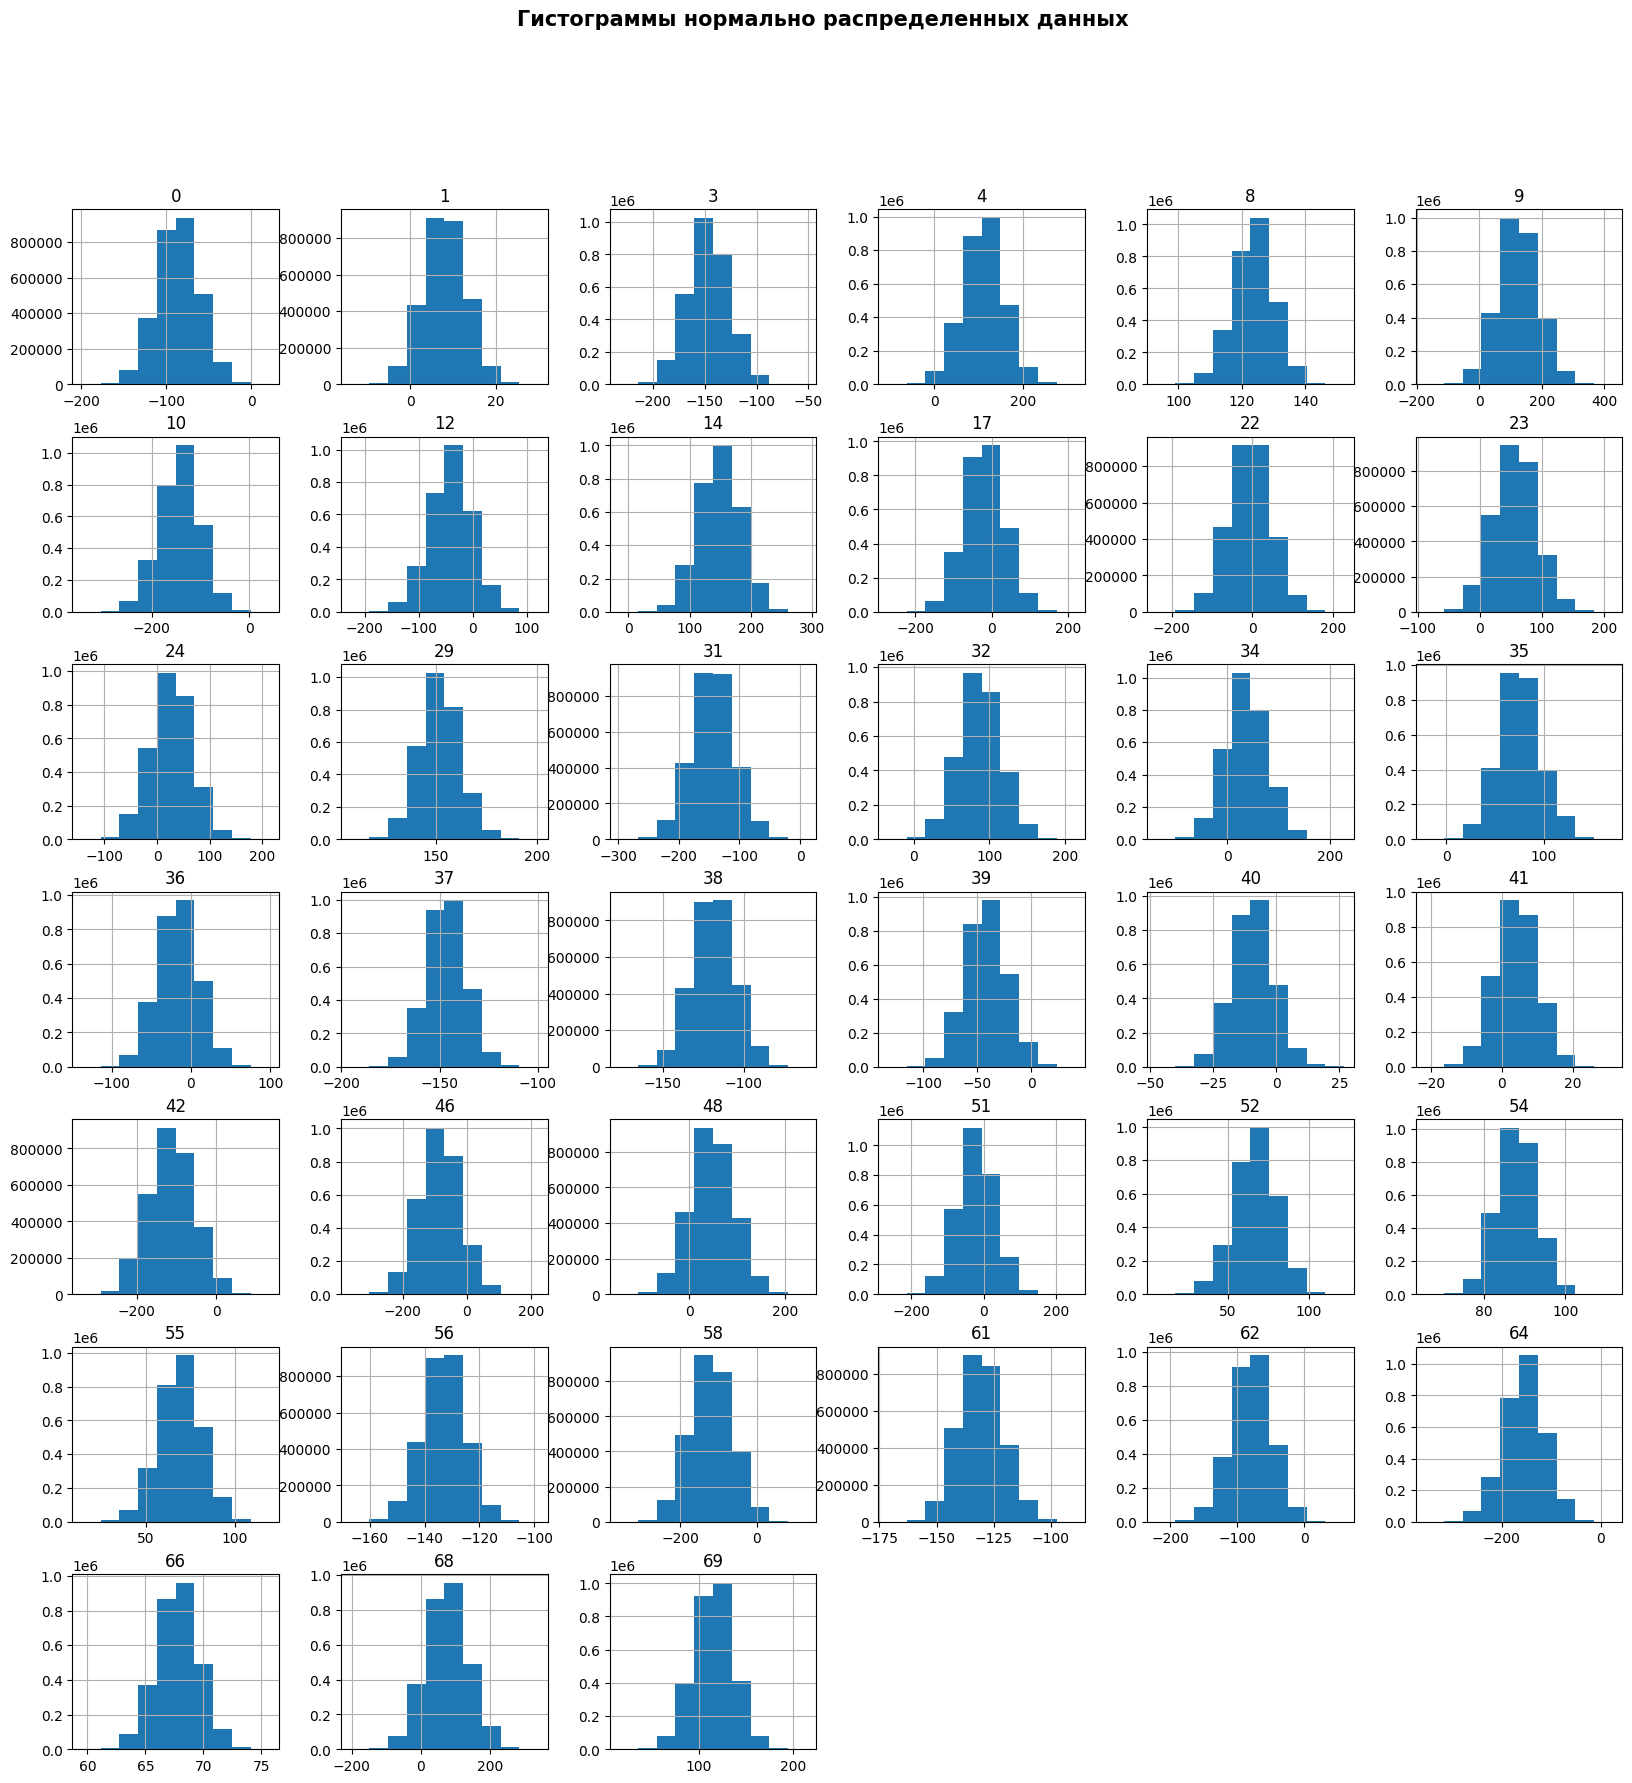

In [46]:
df_base[norm_column].hist(figsize=(20, 20))
plt.suptitle('Гистограммы нормально распределенных данных',
             fontsize=15, fontweight='bold');

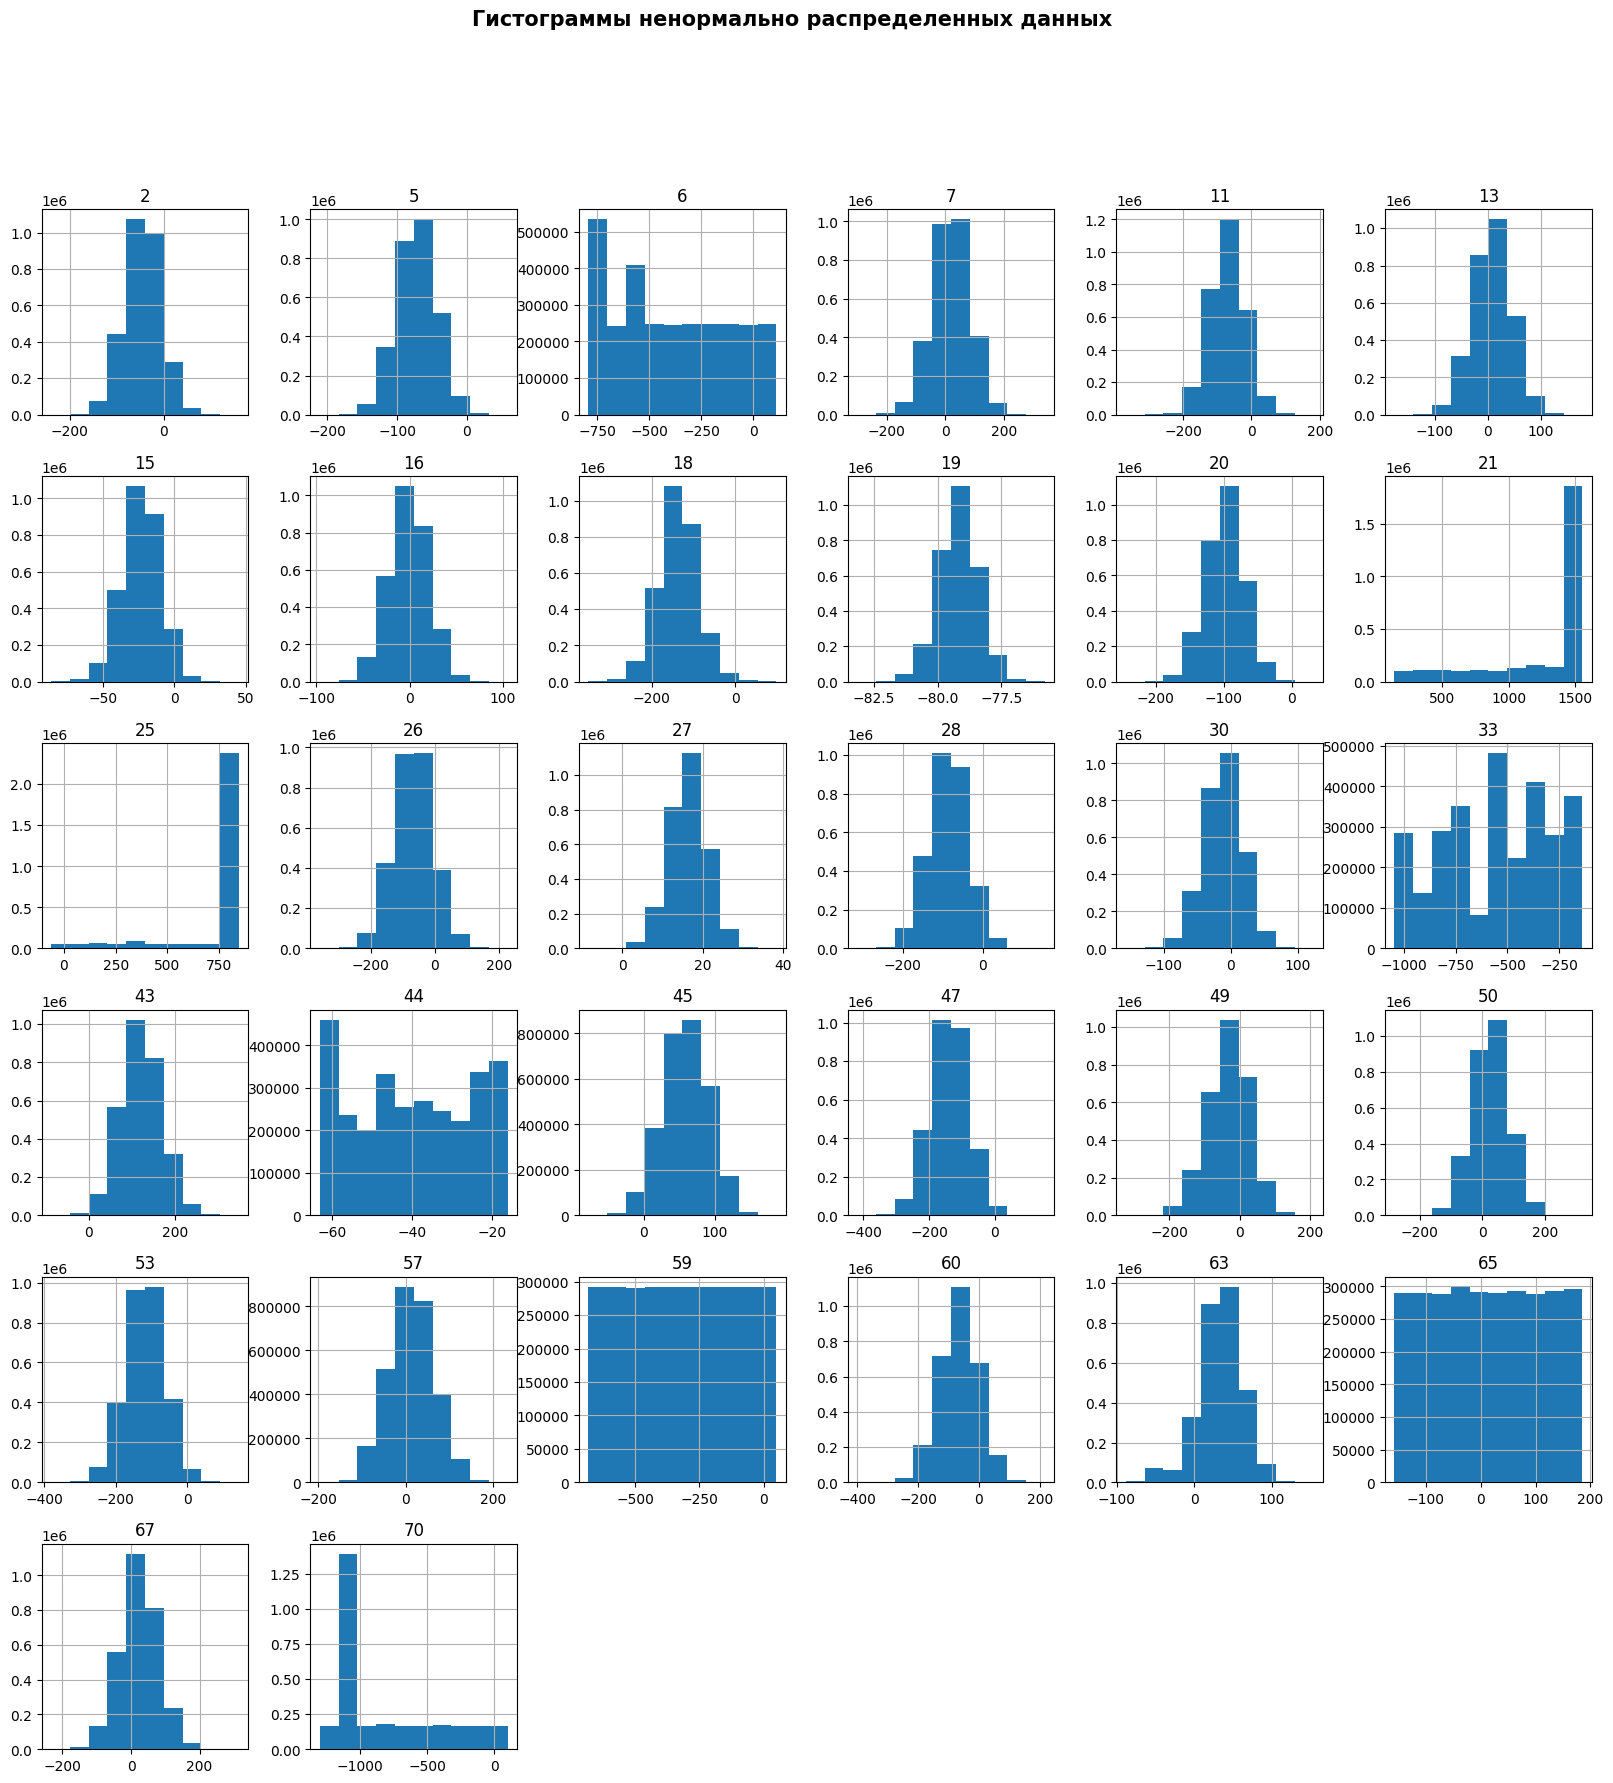

In [47]:
df_base[abnorm_column].hist(figsize=(20, 20))
plt.suptitle('Гистограммы ненормально распределенных данных',
             fontsize=15, fontweight='bold');

Видим и визуально и как показал тест Шапиро-Уилка часть данных распределенны нормально, а часть ненормально. Для части нормально распределенных воспользуемся статистическим тестом Граббса, для определения выбросов (т.к. этот тест применяется только к нормально распределенным данным)

Для определния выбросов у нормально распределенных даных воспользуемся статистическим тестом Граббса. Для этого выдвеним гипотезы и написали функцию `test_grubbs`:
- **H0** - Выбросы в данных отсутсвуют
- **H1** - Выбросы в данных присутсвуют

In [46]:
outlier_column, not_outlier_column = test_grubbs(df_base, ALPHA, norm_column)

Принимаем H0 - 39 раз и делаем вывод об отсутствии выбросов
Отклоняем H0 и принимаем H1 - 0 раз и делаем вывод, что есть выбросы


Теперь необходимо изучить выбросы в данных, которые не имеют нормального распределения. Так как данные у нас анонимизированы, хоть как-то понять, что каждый признак обозначает мы не знаем, а поэтому понять выбросы сложно. Поэтому будем следовать описательной статистики и для этого мы расчитаем 1 и 3 квантили и межкваритльный размах. После значения, которые больше или меньше "усов" будем считать выбросами и заменним их на верхнее либо на нижнее значение границы.

In [52]:
df_base = outliers_iqr(df_base, abnorm_column)

In [53]:
df_train = outliers_iqr(df_train, abnorm_column)

In [54]:
df_validation = outliers_iqr(df_validation, abnorm_column)

## Вывод

В ходе этого раздела было сделано следующие:

1. Визуализировали два признака `5` и `65`. В результате, визуально можно отметить, что данные у нас распределены как нормально, так и не нормально.
2. Следом после визуализации. Воспользовались тестом Шапиро-Улика и выдвинули гипотезы о нормальности распределений. В результате, подвердили наше предположении, что данные распределы нормально и ненормально. В подтверждение  результатов теста по отдельности визуализировали при помощи гистограмм нормально и ненормально распределенные данные.
3. Далее изучили данные на выбросы. Во время загрузки данных, после того как использовали метод `describe` мы заметили, что медиана и среднее в некторых столбцах сильно различаются между собой, что свидетельсвует о наличии выбросов. Так как до этого мы узнали какие данные распределены нормально, то для них воспользовались статистическим тестом Граббса для определения выбросов. Также были выдвинуты и проверены гипотезы. В результате, у нормально распределенных данных выбросов не обнаруженно.
4. Следующий наш шаг был в изучении выбросов у ненормально распределенных данных. В этом случае тестом Граббса уже воспользоваться нельзя (он только для нормально распределенных данных) и в результате, чтобы не строить большое количество графиков типа `boxplot`. Решили расчитать 1 и 3 квантиль (`q1` и `q3`) и межквартильное расстояние (`iqr`), а также размер "усов" (`q1 - iqr * 1.5` и `q3 + iqr * 1.5`). Также пришлось пойти на некоторые уступки, так как данные у нас анонимизированы то понять являются ли на самом деле значения вне "усов" выбросами невозможно, поэтому принимая это во внимание и доверяемся статистике и считаем все значения за пределами "усов" выбросами (скорее всего это не самый лучший вариант, но пришлось пойти на такие уступки). Но "выбросы", которые лежали за пределами "усов" заменили на максимальное и минимальное значение лежащих на верхних и нижних границах графика `boxplot`.

**Итого:** Данные распределенны как нормально, так и ненормально. Нашли выбросы у ненормально распределенных данных и исправили их.

# Корреляционный анализ

Для исследования взаимосвязи между данными воспользуемся сторонней библиотекой `phik`, которая находит коэффициент корреляции $\phi_k$.

Так как данных очень много то будет исследовать корреляцию только для небольшой выборки, которую сделаем при помощи `sample`.

In [ ]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = df_base.sample(10000).phik_matrix(interval_cols=df_base.columns)

In [ ]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(100, 100), pdf_file_name='matrix_corr_base.pdf')

Результат был сохранен в pdf файл. В результате его исследования узнали, что между данными нет мультиколлинеарности. Также между большинством признаков взаимосвязь практически отсутсвует.

Между признаком `63` и `35` есть взаимосвязь - 0.58. Также у признака `63` есть более слабые взаимосвязи с остальными признаками.

Признаки `65`, `59` и `6` не имеют вообще взаимосвязи хоть с кем-то. Скорее всего стоит их удалить

Также проведем анализ для тренировочного и валидационного датасета. Для них также будет создан файл формата pdf.

In [ ]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = df_train.sample(10000).phik_matrix(
    interval_cols=df_train.columns[:-1])

In [ ]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(100, 100), pdf_file_name='matrix_corr_train.pdf')

Между входными данными мультиколлинеарности нет. Только два признака не имеют взаимосвязи с таргетом это `59` и `33`.

In [ ]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = df_validation.sample(10000).phik_matrix(
    interval_cols=df_validation.columns)

In [ ]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(100, 100), pdf_file_name='matrix_corr_valid.pdf')

Между большинством признаков взаимосвязь практически отсутсвует.

Признаки `65`, `59`, `25` и `6` не имеют вообще взаимосвязи хоть с кем-то.

Также признаки `15`, `33`, `67` не вносят никакого вкалада в таргет.

Поэтому выше перечисленные признаки удалим. Также в ходе дальнейшего исследования и еще более подробного изучения матрицы корреляции нашли еще несколько признаков, которые ухудшают работу нашей моделеи, а именно: `2`, `21`, `46`, `49`, `51`, `54` и `57`

In [55]:
# Удаляем столбцы
df_base = df_base.drop(columns=['2', '6', '15', '21', '25', '33', '46', '49',
                                '51', '54', '57', '59', '65', '67'], axis=1)

In [56]:
# Удаляем столбцы
df_train = df_train.drop(columns=['2', '6', '15', '21', '25', '33', '46', '49',
                                  '51', '54', '57', '59', '65', '67'], axis=1)

In [57]:
# Удаляем столбцы
df_validation = df_validation.drop(columns=['2', '6', '15', '21', '25', '33', '46', '49',
                                            '51', '54', '57', '59', '65', '67'], axis=1)

Еще раз построим матрицы корреляций и посмотрим как изменилась взаимосвязь.

In [ ]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = df_base.sample(10000).phik_matrix(interval_cols=df_base.columns)

In [ ]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(100, 100), pdf_file_name='matrix_corr_base2.pdf')

In [ ]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = df_train.sample(10000).phik_matrix(
    interval_cols=df_train.columns[:-1])

In [ ]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(100, 100), pdf_file_name='matrix_corr_train2.pdf')

In [ ]:
# Расчитываем коэффициент корреляции Фи
phik_matrix = df_validation.sample(10000).phik_matrix(
    interval_cols=df_validation.columns)

In [ ]:
plot_correlation_matrix(phik_matrix.values, x_labels=phik_matrix.columns, y_labels=phik_matrix.index,
                        vmin=0, vmax=1, color_map='coolwarm', title='Корреляция $\phi_k$', fontsize_factor=1,
                        figsize=(100, 100), pdf_file_name='matrix_corr_valid2.pdf')

Еще раз проанолизировав взаимосвязи, увидели, что есть еще 5 признаков, которые не вносят никакого вклада, а именно: `5`, `13`, `30`, `47`, `53`. Эти признаки мы тоже удалим.

In [58]:
# Удаляем столбцы
df_base = df_base.drop(columns=['5', '13', '30', '47', '53'], axis=1)

In [59]:
# Удаляем столбцы
df_train = df_train.drop(columns=['5', '13', '30', '47', '53'], axis=1)

In [60]:
# Удаляем столбцы
df_validation = df_validation.drop(
    columns=['5', '13', '30', '47', '53'], axis=1)

# Обучение модели

Для данной задачи воспользуемся библиотекой `FAISS`. Хоть мы и удалили часть признаков из наших датафреймов их все еще много, поэтому воспользуемся методом главных компонет `PCA` и постараемся еще уменьшить их количество. Для того, чтобы использовать `PCA` необоходимо выполнить стандартизацию, делать мы будем это методом `StandardScaler`.

Перед выполнением стандартизации необходимо отделить таргет в тренировочной выборке. Также сразу отделим правильные ответы для валидационной выборки в отлельную переменную.

In [61]:
targets = df_train['Target']  # Сохраняем таргет

# Отделяем таргет от всех значений
df_train = df_train.drop(columns=['Target'], axis=1)

In [62]:
answer = df_answer['Expected']  # Сохраняем отдельно ответы

Теперь мы можем приступать к стандартизации.

In [63]:
# Инициализируем модель
scaler = StandardScaler()

In [64]:
base_scal = scaler.fit_transform(df_base)

# Создаем датафрейм со стандартизированными значениями
df_base_scal = pd.DataFrame(base_scal, columns=df_base.columns)

In [65]:
train_scal = scaler.transform(df_train)

# Создаем датафрейм со стандартизированными значениями
df_train_scal = pd.DataFrame(train_scal, columns=df_train.columns)

In [66]:
val_scal = scaler.transform(df_validation)

# Создаем датафрейм со стандартизированными значениями
df_val_scal = pd.DataFrame(val_scal, columns=df_validation.columns)

После проделанных операций мы можем применять метод `PCA`. При инициализации данного метода, поставим улсовием, чтобы метод выбирал минимальное количество главных компонентов, при котором сохранится 95 процентов дисперсии.

In [67]:
# Инициализируем метод PCA
pca = PCA(.95)

In [68]:
# Обучаем и применяем PCA к base
base_scal_pca = pca.fit_transform(df_base_scal)

In [69]:
# Проверяем количество главных компонет
pca.n_components_

48

In [70]:
# Создаем датафрейм с тем же количество столбцов, что и главных компонент
df_base_pca = pd.DataFrame(base_scal_pca,
                           columns=([f'col{col}' for col in range(0, pca.n_components_)]))

df_base_pca.index = df_base.index  # Меняем индексы в созданом датафрейме

In [71]:
# Применяем PCA к тренировочной выборке
train_scal_pca = pca.transform(df_train_scal)

# Создаем датафрейм с тем же количество столбцов, что и главных компонент
df_train_pca = pd.DataFrame(train_scal_pca,
                            columns=([f'col{col}' for col in range(0, pca.n_components_)]))

df_train_pca.index = df_train.index  # Меняем индексы в созданом датафрейме

In [72]:
# Применяем PCA к валидационной выборке
valid_scal_pca = pca.transform(df_val_scal)

# Создаем датафрейм с тем же количество столбцов, что и главных компонент
df_valid_pca = pd.DataFrame(valid_scal_pca,
                            columns=([f'col{col}' for col in range(0, pca.n_components_)]))

# Меняем индексы в созданом датафрейме
df_valid_pca.index = df_validation.index

Можем приступать к обучению модели методом `FAISS`, будем использовать `IndexFlatL2` - используется в кчасетве шага квантования совместно с `IndexIVFFlat` - используется для тесселяции Вороного. Для этого необходимо задать векторную размерность, количество ячеек Вороного и в скольких ячейках необходимо проводить поиск.

In [78]:
dims = df_base_pca.shape[1]  # Векторная размерность

In [79]:
n_list = 40  # Указываем количество ячеек Вороного

In [80]:
# Создаем объект класса index и измеряем между всеми точками Евклидово расстояние
# используем его в качестве шага квантования
quantizer = faiss.IndexFlatL2(dims)

In [81]:
# Создаем индекс секционирования
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_list)

In [82]:
# Обучаем индекс на наших данных
idx_l2.train(np.ascontiguousarray(df_base_pca.values).astype('float32'))

In [83]:
# Проверяем обучился ли индекс
idx_l2.is_trained

True

In [84]:
idx_l2.add(np.ascontiguousarray(df_base_pca.values).astype('float32'))
idx_l2.ntotal  # Количество проиндексированных вложений

291813

In [85]:
base_index = {k: v for k, v in enumerate(df_base_pca.index.to_list())}

In [86]:
idx_l2.nprobe = 20  # Указываем сколько соседних ячеек необходимо искать

In [87]:
candidate_number = 5  # Задаем ближайших соседей

# Находим расстояние до соседей и индексы ближайших соседей
dist, idx = idx_l2.search(np.ascontiguousarray(
    df_train_pca.values).astype('float32'), candidate_number)

In [88]:
# Рассчитываем метрику accuracy@5
acc = 0
for target, el in zip(targets.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[dist] for dist in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 72.2%


Проверяем результаты на валидационной выборке.

In [89]:
# Находим расстояние до соседей и индексы ближайших соседей
dist, idx = idx_l2.search(np.ascontiguousarray(
    df_valid_pca.values).astype('float32'), candidate_number)

In [90]:
# Рассчитываем метрику accuracy@5
acc = 0
for target, el in zip(answer.values.tolist(), idx.tolist()):
    acc += int(target in [base_index[dist] for dist in el])
print(f'Accuracy @ {candidate_number} = {acc / len(idx):.1%}')

Accuracy @ 5 = 71.4%


# Общий вывод

Данные были получены из:

- `base.csv`
- `train.csv`
- `validation.csv`
- `validation_answer.csv`

сами данные харнились в `zip`-файлах полная и неполная версия:

- `data_full.zip`
- `data.zip`

Все данные были анонимизированны. Известно только, что каждая строка таблицы содержит информацию о каком-то товаре.

В начале сделали обзор данных. В дальнейшем все исследование проходило в 6 этапов.

1. Изучить данные
2. Предобработка данных
3. Исследовательский анализ данных
4. Корреляционные анализ
5. Обучение моделей
6. Общий вывод

Перед нами стояла задача мэтчинга. Оценить успешность ее выполнения требовалось по метрике `accuracy@5`. Желательно получить результат > 70%



---



**1. Изучение данных**

Файл `base.csv` сохранили в переменную `df_base`. В результате изучения выяснили, что всего в таблице 72 столбца, тип данных - `float`(72).

Файл `train.csv` сохранили в переменную `df_train`. Всего в таблице 73 столбца, тип данных - `float`(72) и `object`(1).

Файл `validation.csv` сохранили в переменную `df_validation`. Всего в таблице 72 столбца, тип данных - `float`(72).

Файл `validation_answer.csv` сохранили в переменную `df_answer`. Всего в таблице 1 столбец, тип данных - `object`(1).


Так как у нас было два `zip` файла с разной размерностью данных для удобства их считывания была написана функция `open_zip`.

Ко всем таблицам применили методы `info` и `describe` (кроме `df_answer`, т.к содержит только категориальные данные), что в итоге нам дало следующее. Мы увидели, что значения в столбцах одинаковые, а значит пропусков нет. Хоть данные у нас и анонимизированны, но исходя из описательной статистики заметили, что у многих признаков сильно отличается значение медианы и среднего, что может говорить о наличии выбросов.

По результатам этого пункта отметили для себя дальнейшие действия:
- Первичный осмотр показал, что пропусков нет, но лучше еще раз все проверить.
- Сделать проверку на явные и неявные дубликаты.
- При исследовательском анализе стоит разобраться с выбросами.



---



**2. Предобработка данных**

В предыдушем разделе наметили для себя путь, поэтому стали следовать ему.

Провели проверку всех таблиц на пропуски в данных. Как и показал первичный осмотр, никаких пропусков в данных нет.

Далее приступили к изучению явных дубликатов и для облегчения написали функцию `dupl`. С ее помощью находили дубликаты и по необходимости их удаляли.

Последней целью нашего намеченого пути стал поиск неявных дубликатов. В столбцах `Target` и `Expected` привели все значения к нижнему регистру, а также удалили пробелы в начале и в конце строки.

По результатам этого пункта выполнили предобработку и часть целей, которые поставили в первом разделе.



---

**3. Исследовательский анализ данных**

В ходе исследовательского анализа необходимо было изучить распределение данных и разобраться с выбросами в данных (как мы предположили в первом разделе, что они есть)

Решили работать только с `df_base`, так как все остальные таблицы получены из него, что дает нам право работать только с родительской выборкой, так как мы предполагаем, что все остальные выборки репрезентативны и отражают свойства `df_base`, а следовательно все выводы по `df_base` буду действительны и для `df_train` и `df_validation`.

В начале выборочно решили визуализировать два признака. Выбор пал на `5` и `65`. Для этих двух признаков построили `boxplot` и гистограмму распределений. Отметили предварительно для себя следующее, данные распределенны как нормально, так и не нормально. В данных могут быть выбросы (по результатам изучения графика `boxplot`)

Чтобы точно убедится, что данные у нас могут иметь нормальное распределение Воспользовались тестом Шапиро-Улика и выдвинули гипотезы о нормальности распределений. (Для него была написана отдельная функция `test_shapiro`)
В результате, подвердили наше предположения, что некоторые данные распределы нормально, но также есть и ненормально распределенные данные. В подтверждение  результатов теста по отдельности визуализировали при помощи гистограмм нормально и ненормально распределенные данные.

Выдвинутые гипотезы:

- **H0** - Данные получены из нормального распределения
- **H1** - Данные не получены из нормального распределения

Далее изучили данные на выбросы. Так как в первом разделе отметили для себя странное отличие медианы и среднего, а также потвердили для себя графиком `boxplot`. До этого мы узнали какие данные распределены нормально, то для них воспользовались статистическим тестом Граббса для определения выбросов. (Для него была написана отдельная функция `test_grubbs`) Выдвинули и проверили гипотезы. В результате, у нормально распределенных данных выбросов не обнаруженно.

Выдвинутые гипотезы:

- **H0** - Выбросы в данных отсутсвуют
- **H1** - Выбросы в данных присутсвуют


Далее исследовали выбросы у ненормально распределенных данных. Их выделили отдельно, так как для них нельзя использовать тест Граббса (используется только для нормально распределенных даных). Так как данные у нас анонимизированы и понять являются ли какие-то из значений выбросами невозможно. В таком случае решили пойти на уступки и было принято решение расчитать 1 и 3 квантиль (`q1` и `q3`) и межквартильное расстояние (`iqr`), а также размер "усов" (`q1 - iqr * 1.5` и `q3 + iqr * 1.5`). Значения, которые лежали за пределами "усов" посчитали выбросами и заменили на максимальное и минимальное значение лежащих на верхних и нижних границах графика `boxplot`. (Для этого была написана функция `outliers_iqr`)

По результатам этого пункта узнали и доказали статистически, что данные распределенны как нормально так и ненормально. Также нашли выбросы у ненормально распределенных данных и исправили их. У нормально распределенных данных выбросов не обнаружено.



---

**4. Корреляционный анализ**

Для исследования взаимосвязи между данными воспользовались сторонней библиотекой `phik`, которая находит коэффициент корреляции $\phi_k$.

Так как данных очень много то исследовали корреляцию только для небольшой выборки, которую сделаем при помощи `sample`. И так как признаков очень много для более детально и удобно их рассмотрения матрицу корреляции сохранили в `pdf`-файле.

Исследование взаимосвязи данных проводили для всех датафреймов. В результате проведения этого анализа выяснили, что между большинством признаков взаимосвязь практически отсутсвует.

Признаки `65`, `59`, `25` и `6` не имеют вообще взаимосвязи хоть с кем-то.

Признаки `15`, `33`, `67` не вносят никакого вкалада в таргет.

Также в ходе дальнейшего исследования и еще более подробного изучения матрицы корреляции нашли еще несколько признаков, которые ухудшают работу нашей модели, а именно: `2`, `21`, `46`, `49`, `51`, `54` и `57`

Построили еще раз матрицу корреляций для всех датафреймов, чтобы посмотреть как изменилась взаимосвязь между признаками и увидели, что есть еще 5 признаков, которые не вносят никакого вклада, а именно: `5`, `13`, `30`, `47`, `53`.

По итогу все выше перечисленные признаки были удалены.



---

**5. Обучение модели**

Для данной задачи воспользовались библиотекой `FAISS`. Но перед тем как приступать к обучению сделали предподготовку данных и воспользовались методом главных компонент `PCA` для того, чтобы еще уменьшить размерность нашего датафрейма. Также была выполнена стандартизация при помощи метода `StandardScaler`.

При инициализации `PCA`, поставили улсовие, чтобы метод выбирал минимальное количество главных компонентов, при котором сохранится `95%` дисперсии.

В результате уменьшили нашу размерность до **48**

После выполнения предподготовки приступили к обучению модели. Использовали:

- `IndexFlatL2` - используется в качестве шага квантования 
- `IndexIVFFlat` - используется для тесселяции Вороного.

остановились на значения **40** и **20** соотвественно.

Результаты работы модели на тренировочной и валидационной выборке представелны в табилце.

| Выборка | Accuracy@5| Метрика > 70%| Время |
|:----------|:----------:|:----------:|:----------:|
| **Тренировочная**    | 72.2%   |  ✅   | 2 ч. 7 мин.   |
| **Валидационная**  | 71.4%  |  ✅   |2 ч. 20 мин. |


---

**Вывод**


По результатам исследования можно сказать, что работа основной задачей, которой была **задача мэтчинга** выполнена на что указывает значение метрики по-разным выборкам (>70%) ✅. Также стоит отметить, что пришлось пойти на разные уступки такие как:
- Не слишком полно исследованы неявные дубликаты ❗
- Из-за анонимизации данных значения, которые превышают "усы" посчитали выбросами и заменили их на другие значения ❗